## M2 review
- 실사 이미지로 분류된 이미지 제외하고 가져옴(update.csv)


In [ ]:
import random
import pandas as pd
import numpy as np
import os
import cv2
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings(action='ignore') 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/update.csv')

In [ ]:
#실사 이미지 제거 후 데이터셋
df

,Unnamed: 0,Unnamed: 0.1,name,label,width,height,pixel
0,0,0,ycrqupsfbtdmppsedlxl.jpg,L2_10,700.0,700.0,175.475408
1,1,1,oqfadnuqsmolzmxwfycm.jpg,L2_10,300.0,300.0,187.451700
2,2,2,edkxyljaevluzpccthfb.jpg,L2_10,700.0,700.0,204.499047
3,3,3,qfcrkaiksvpsezumhlvi.jpg,L2_10,300.0,300.0,191.282344
4,4,4,rtfhhjiiawrrdtcxjxyz.jpg,L2_10,700.0,700.0,195.024749
...,...,...,...,...,...,...,...
12658,12721,25116,fuseaskyinprevqkhsdk.jpg,L2_50,500.0,375.0,74.890048
12659,12722,25117,twkasgjdtqledyskhers.jpg,L2_50,500.0,375.0,118.503961
12660,12723,25118,ezohpeivibzejiorwosq.jpg,L2_50,500.0,375.0,129.514617
12661,12724,25119,ftlhnlgkaeecmktdcvet.jpg,L2_50,500.0,375.0,108.577918


## M3

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/bh/data'

In [ ]:
#이미지 경로 칼럼 추가
df['img_path'] = data_dir + '/' + df['label'] + '/' + df['name']
df['img_path']

0        /content/drive/MyDrive/Colab Notebooks/bh/data...
1        /content/drive/MyDrive/Colab Notebooks/bh/data...
2        /content/drive/MyDrive/Colab Notebooks/bh/data...
3        /content/drive/MyDrive/Colab Notebooks/bh/data...
4        /content/drive/MyDrive/Colab Notebooks/bh/data...
                               ...                        
12658    /content/drive/MyDrive/Colab Notebooks/bh/data...
12659    /content/drive/MyDrive/Colab Notebooks/bh/data...
12660    /content/drive/MyDrive/Colab Notebooks/bh/data...
12661    /content/drive/MyDrive/Colab Notebooks/bh/data...
12662    /content/drive/MyDrive/Colab Notebooks/bh/data...
Name: img_path, Length: 12663, dtype: object

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 32.3 MB/s 
     |████████████████████████████████| 1.6 MB 58.5 MB/s 


In [ ]:
import tensorflow as tf
import cv2
import math
import scipy as sp
import PIL
import logging
import matplotlib.style as style
import seaborn as sns

from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D, BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from keras_tuner.tuners import RandomSearch

from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [ ]:
#train과 test데이터 8:2의 비율로 분리
X_train, X_test, y_train, y_test = train_test_split(df, df['label'].values, test_size=0.2)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_test))

Number of posters for training:  10130
Number of posters for validation:  2533


In [ ]:
X_train['label'].value_counts()

L2_46    1761
L2_10    1507
L2_15    1215
L2_25     589
L2_33     584
L2_45     515
L2_44     438
L2_39     368
L2_27     334
L2_20     331
L2_34     330
L2_21     329
L2_24     311
L2_50     307
L2_52     306
L2_30     289
L2_3      229
L2_40     146
L2_12     129
L2_41     112
Name: label, dtype: int64

In [ ]:
X_test['label'].value_counts()

L2_46    453
L2_10    386
L2_15    294
L2_33    146
L2_25    141
L2_45    116
L2_44    109
L2_27     92
L2_34     89
L2_39     86
L2_50     85
L2_21     81
L2_20     79
L2_52     76
L2_30     75
L2_24     74
L2_3      54
L2_40     34
L2_12     34
L2_41     29
Name: label, dtype: int64

In [ ]:
#batch_size, epochs, 학습률, 이미지 크기 설정
batch_size = 128
epochs = 10
LearningRate = 1e-3 # 0.001
Decay = 1e-6
img_width = 224
img_height = 224

In [ ]:
pool_size = 2

# Build the model.     
model = Sequential([
  keras.Input(shape=(img_width,img_height,3)),
  Conv2D(filters = 50, kernel_size = (1,1), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),                                           
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), 
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D(pool_size=pool_size),                         

  Conv2D(filters = 80, kernel_size = (1,1), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(filters = 80, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),   
  Conv2D(filters = 80, kernel_size = (3,3), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D(pool_size=pool_size),                         

  Conv2D(filters = 120, kernel_size = (1,1), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(filters = 120, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),   
  Conv2D(filters = 120, kernel_size = (3,3), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D(pool_size=pool_size),                         

  Flatten(),
  Dense(50),
  Activation('relu'),                                          
  
  Dense(20, activation='softmax'),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 224, 224, 50)      200       
                                                                 
 batch_normalization_9 (Batc  (None, 224, 224, 50)     200       
 hNormalization)                                                 
                                                                 
 activation_10 (Activation)  (None, 224, 224, 50)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 50)      22550     
                                                                 
 batch_normalization_10 (Bat  (None, 224, 224, 50)     200       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 224, 224, 50)     

In [ ]:
# Compile the model                       
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
#Data augmentation, 평가데이터셋 분리 비율 설정
DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    data_format="channels_last",
    validation_split=0.3)

In [ ]:
# Generator의 instance 생성
TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
                                        dataframe = X_train, x_col='img_path', y_col='label',
                                        target_size=(img_height, img_width), 
                                        class_mode='categorical',
                                        batch_size=batch_size, shuffle=True,
                                        subset = "training")
 
VALID_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
                                        dataframe = X_train, x_col='img_path', y_col='label',
                                        target_size=(img_height, img_width), 
                                        class_mode='categorical',
                                        batch_size=batch_size, shuffle=True,
                                        subset = "validation")

Found 7091 validated image filenames belonging to 20 classes.
Found 3039 validated image filenames belonging to 20 classes.


In [ ]:
#ModelCheckpoint 설정
CP = ModelCheckpoint(filepath='/content/drive/MyDrive/checkpoint/' +
                     'model-Sigmoid-{epoch:03d}-{loss:.4f}-{val_loss:.4f}.ckpt',
     monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=5, verbose=1, min_lr=0.00005)
CALLBACK = [CP, LR]

In [ ]:
#모델 학습
history= model.fit(
    TRAIN_GENERATOR,
    epochs=epochs,
    callbacks=CALLBACK,
    shuffle=True,
    validation_data=VALID_GENERATOR)

Epoch 1/10
56/56 [==============================] - ETA: 0s - loss: 5.3831 - accuracy: 0.1283 
Epoch 1: val_accuracy improved from -inf to 0.16255, saving model to /content/drive/MyDrive/checkpoint/model-Sigmoid-001-5.3831-3.3785.ckpt


56/56 [==============================] - 988s 18s/step - loss: 5.3831 - accuracy: 0.1283 - val_loss: 3.3785 - val_accuracy: 0.1626 - lr: 0.0010
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 2.7595 - accuracy: 0.1623
Epoch 2: val_accuracy did not improve from 0.16255
56/56 [==============================] - 386s 7s/step - loss: 2.7595 - accuracy: 0.1623 - val_loss: 2.7353 - val_accuracy: 0.1537 - lr: 0.0010
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 2.7088 - accuracy: 0.1681
Epoch 3: val_accuracy improved from 0.16255 to 0.20270, saving model to /content/drive/MyDrive/checkpoint/model-Sigmoid-003-2.7088-2.7075.ckpt


56/56 [==============================] - 383s 7s/step - loss: 2.7088 - accuracy: 0.1681 - val_loss: 2.7075 - val_accuracy: 0.2027 - lr: 0.0010
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 2.6681 - accuracy: 0.1677
Epoch 4: val_accuracy improved from 0.20270 to 0.20434, saving model to /content/drive/MyDrive/checkpoint/model-Sigmoid-004-2.6681-2.6984.ckpt


56/56 [==============================] - 388s 7s/step - loss: 2.6681 - accuracy: 0.1677 - val_loss: 2.6984 - val_accuracy: 0.2043 - lr: 0.0010
Epoch 5/10
56/56 [==============================] - ETA: 0s - loss: 2.6365 - accuracy: 0.1729
Epoch 5: val_accuracy did not improve from 0.20434
56/56 [==============================] - 385s 7s/step - loss: 2.6365 - accuracy: 0.1729 - val_loss: 2.6733 - val_accuracy: 0.1945 - lr: 0.0010
Epoch 6/10
56/56 [==============================] - ETA: 0s - loss: 2.6110 - accuracy: 0.1709
Epoch 6: val_accuracy did not improve from 0.20434
56/56 [==============================] - 384s 7s/step - loss: 2.6110 - accuracy: 0.1709 - val_loss: 2.6118 - val_accuracy: 0.1632 - lr: 0.0010
Epoch 7/10
56/56 [==============================] - ETA: 0s - loss: 2.5917 - accuracy: 0.1816
Epoch 7: val_accuracy did not improve from 0.20434
56/56 [==============================] - 380s 7s/step - loss: 2.5917 - accuracy: 0.1816 - val_loss: 2.5926 - val_accuracy: 0.1820 - lr: 

56/56 [==============================] - 388s 7s/step - loss: 2.5426 - accuracy: 0.1974 - val_loss: 2.4876 - val_accuracy: 0.2116 - lr: 0.0010
Epoch 9/10
56/56 [==============================] - ETA: 0s - loss: 2.4658 - accuracy: 0.2082
Epoch 9: val_accuracy improved from 0.21158 to 0.22080, saving model to /content/drive/MyDrive/checkpoint/model-Sigmoid-009-2.4658-2.4371.ckpt


56/56 [==============================] - 390s 7s/step - loss: 2.4658 - accuracy: 0.2082 - val_loss: 2.4371 - val_accuracy: 0.2208 - lr: 0.0010
Epoch 10/10
56/56 [==============================] - ETA: 0s - loss: 2.4475 - accuracy: 0.2141
Epoch 10: val_accuracy did not improve from 0.22080
56/56 [==============================] - 383s 7s/step - loss: 2.4475 - accuracy: 0.2141 - val_loss: 2.4597 - val_accuracy: 0.2011 - lr: 0.0010


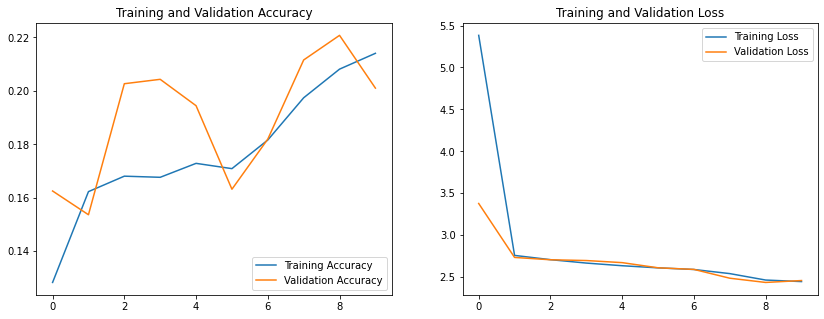

In [ ]:
# accuracy, loss 그래프
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255)

TEST_GENERATOR = DATAGEN_TEST.flow_from_dataframe(
                                        dataframe = X_test, x_col='img_path', y_col='label',
                                        target_size=(img_height, img_width), 
                                        class_mode='categorical',
                                        batch_size=2533, shuffle=True)

Found 2533 validated image filenames belonging to 20 classes.


In [ ]:
model.load_weights('/content/drive/MyDrive/checkpoint/model-Sigmoid-010-2.7012-2.7165.ckpt')

In [ ]:
predict=model.predict(TEST_GENERATOR)

20/20 [==============================] - 214s 11s/step


In [ ]:
print(TEST_GENERATOR.class_indices)

{'L2_10': 0, 'L2_12': 1, 'L2_15': 2, 'L2_20': 3, 'L2_21': 4, 'L2_24': 5, 'L2_25': 6, 'L2_27': 7, 'L2_3': 8, 'L2_30': 9, 'L2_33': 10, 'L2_34': 11, 'L2_39': 12, 'L2_40': 13, 'L2_41': 14, 'L2_44': 15, 'L2_45': 16, 'L2_46': 17, 'L2_50': 18, 'L2_52': 19}


In [ ]:
y_predict=np.argmax(predict,axis=1)

In [ ]:
le = preprocessing.LabelEncoder()
y_test_enc = le.fit_transform(y_test)
y_test_enc

array([ 4, 12, 15, ...,  8, 15,  2])

In [ ]:
f1_score(y_test_enc,y_predict, average='micro')

0.13541255428345836

In [ ]:
print(classification_report(y_test_enc, y_predict, target_names=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19']))

              precision    recall  f1-score   support

           0       0.15      0.36      0.21       386
           1       0.00      0.00      0.00        34
           2       0.10      0.20      0.14       294
           3       0.00      0.00      0.00        79
           4       0.00      0.00      0.00        81
           5       0.03      0.01      0.02        74
           6       0.00      0.00      0.00       141
           7       0.00      0.00      0.00        92
           8       0.04      0.07      0.05        54
           9       0.00      0.00      0.00        75
          10       0.00      0.00      0.00       146
          11       0.00      0.00      0.00        89
          12       0.00      0.00      0.00        86
          13       0.00      0.00      0.00        34
          14       0.00      0.00      0.00        29
          15       0.00      0.00      0.00       109
          16       0.00      0.00      0.00       116
          17       0.17    